In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
     

In [273]:
# Import CSV to Pandas
link ="./global-hourly-2024-01-02T20-32-28.csv"
data = pd.read_csv(link,usecols=["TMP","REPORT_TYPE","DATE"],dtype={"WND": str, "REPORT_TYPE": str, "DATE": str})

In [274]:
# Remove SOD and SOM reports 
data = data[~data['REPORT_TYPE'].isin(['SOD  ','SOM  '])]

In [275]:
split_values = data['TMP'].str.split(',', expand=True)
num_columns = len(split_values.columns)
split_values.columns = ["Temp","Quality"]
data = pd.concat([data, split_values], axis=1)

In [276]:
data['Temp'] = data['Temp'].astype(int)

In [277]:
data['Temp'] = data['Temp'] / 10

In [278]:
data = data[~data['Quality'].isin(['9'])]

In [279]:
data.drop(["REPORT_TYPE","TMP","Quality"],axis=1,inplace=True)

In [280]:
print(data)

                       DATE  Temp
0       2000-01-01T00:53:00   9.0
1       2000-01-01T01:53:00   7.0
2       2000-01-01T02:53:00   6.0
3       2000-01-01T03:53:00   4.0
4       2000-01-01T04:08:00   6.0
...                     ...   ...
296444  2023-12-31T17:53:00  11.1
296445  2023-12-31T18:53:00  11.1
296446  2023-12-31T19:11:00  11.7
296447  2023-12-31T19:53:00  12.2
296448  2023-12-31T20:53:00  13.9

[285557 rows x 2 columns]


In [281]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,285557.0,12.467617,6.796791,-17.0,8.3,11.7,15.6,43.9


In [282]:
data['DATE'] = pd.to_datetime(data['DATE'])
print(data)
# data = data.set_index('date')
# data = data.drop(['DATE'], axis=1)


weather = data #.resample('2H', on="DATE").mean()

                      DATE  Temp
0      2000-01-01 00:53:00   9.0
1      2000-01-01 01:53:00   7.0
2      2000-01-01 02:53:00   6.0
3      2000-01-01 03:53:00   4.0
4      2000-01-01 04:08:00   6.0
...                    ...   ...
296444 2023-12-31 17:53:00  11.1
296445 2023-12-31 18:53:00  11.1
296446 2023-12-31 19:11:00  11.7
296447 2023-12-31 19:53:00  12.2
296448 2023-12-31 20:53:00  13.9

[285557 rows x 2 columns]


In [283]:
# weather.to_csv("output3.csv",index=False)

Text(0.5, 1.0, "Istanbul's Monthly Averate Temperature Data")

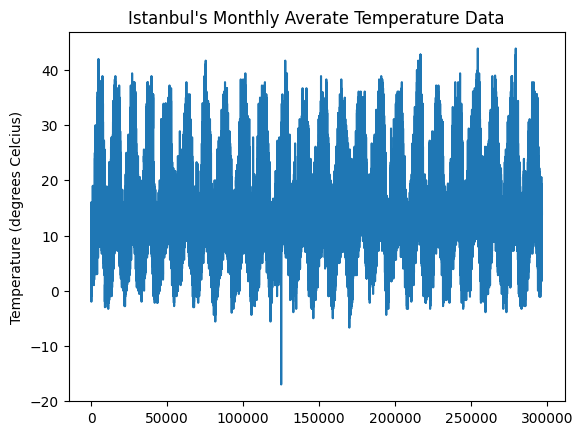

In [284]:
plt.plot(weather['Temp'])
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Istanbul's Monthly Averate Temperature Data")

In [285]:
#Taking a deep copy of the weather DataFrame
weather_linear = weather.copy(deep=True)
print(weather)
print(weather_linear["DATE"])
weather_linear['month'] = pd.DatetimeIndex(weather_linear['DATE']).month

#One-hot-encoding of month data
weather_linear = pd.get_dummies(weather_linear, columns = ['month'])
weather_linear.head(2)

                      DATE  Temp
0      2000-01-01 00:53:00   9.0
1      2000-01-01 01:53:00   7.0
2      2000-01-01 02:53:00   6.0
3      2000-01-01 03:53:00   4.0
4      2000-01-01 04:08:00   6.0
...                    ...   ...
296444 2023-12-31 17:53:00  11.1
296445 2023-12-31 18:53:00  11.1
296446 2023-12-31 19:11:00  11.7
296447 2023-12-31 19:53:00  12.2
296448 2023-12-31 20:53:00  13.9

[285557 rows x 2 columns]
0        2000-01-01 00:53:00
1        2000-01-01 01:53:00
2        2000-01-01 02:53:00
3        2000-01-01 03:53:00
4        2000-01-01 04:08:00
                 ...        
296444   2023-12-31 17:53:00
296445   2023-12-31 18:53:00
296446   2023-12-31 19:11:00
296447   2023-12-31 19:53:00
296448   2023-12-31 20:53:00
Name: DATE, Length: 285557, dtype: datetime64[ns]


,DATE,Temp,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2000-01-01 00:53:00,9.0,True,False,False,False,False,False,False,False,False,False,False,False
1,2000-01-01 01:53:00,7.0,True,False,False,False,False,False,False,False,False,False,False,False


In [286]:
#Fitting a linear regression to data from 1991 to 2018, using 2019 to 2022 as test set
train_data =  weather_linear[weather_linear['DATE'] < '2019-01-01']
test_data = weather_linear[weather_linear['DATE'] >= '2019-01-01']
regression = LinearRegression().fit(train_data.iloc[:,-12:], train_data['Temp'])

In [287]:
weather_pred = regression.predict(test_data.iloc[:,-12:])
test_data['prediction'] = weather_pred
print("Mean squared error: %.3f" % mean_squared_error(test_data['Temp'], weather_pred))

print("Coefficient of determination: %.3f" % r2_score(test_data['Temp'], weather_pred))
test_data.head(2)


Mean squared error: 33.555
Coefficient of determination: 0.300


C:\Users\Lande\AppData\Local\Temp\ipykernel_52732\2116860593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = weather_pred


,DATE,Temp,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,prediction
233527,2019-01-01 00:53:00,10.6,True,False,False,False,False,False,False,False,False,False,False,False,7.397166
233528,2019-01-01 01:53:00,9.4,True,False,False,False,False,False,False,False,False,False,False,False,7.397166


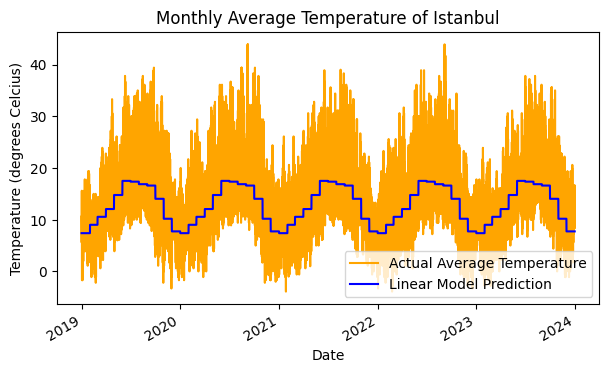

In [289]:

#Plotting actual temperatures vs. predictions of the linear model (using month of year as features)
test_data.set_index('DATE', inplace=True)
plt.figure(figsize=(7, 4), dpi=100)

test_data['Temp'].plot(label='Actual Average Temperature', color='orange')
test_data['prediction'].plot(label='Linear Model Prediction', color='blue')

plt.title('Monthly Average Temperature of Istanbul')
plt.xlabel('Date')
plt.ylabel('Temperature (degrees Celcius)')

plt.legend(loc='lower right')
     